In [1]:
import pandas as pd
import datetime
import json
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
from matplotlib.image import imread
from keras.preprocessing import image
from sklearn.metrics import r2_score
import seaborn as sns

Using TensorFlow backend.


### Pulling stock list from Virtus LifeSci Biotech ETF

In [0]:
stocks = pd.read_excel('positions_bbc.xls', index_col=0, skiprows=1).Ticker.values

In [3]:
pdr.get_data_yahoo(stocks[0], start='2000-01-01').head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-07,17.00,15.000000,16.0,15.000000,59800,15.000000
2014-01-08,18.00,16.000000,17.5,17.000000,51100,17.000000
2014-01-09,17.75,17.100000,17.5,17.500000,159900,17.500000
2014-01-10,20.00,17.500000,17.5,18.000000,157100,18.000000
2014-01-13,18.50,18.200001,18.4,18.200001,5000,18.200001


#### Creating dictionary and JSON

In [0]:

dataframe_dict= {}
for stock in stocks: 

    df = pdr.get_data_yahoo(stock, start='2000-01-01')
    # Change inde to a date  string
    df['Date'] = df.index.strftime("%Y-%m-%d %H:%M:%S")
    
    dataframe_dict[stock] = df.to_dict('records')


In [0]:
data = dataframe_dict

### Creating a dictionary and JSON for Benchmark index and ETF

```python
benchmark_dict = {}
# SP500(broader market)
df = pdr.get_data_yahoo('SPY', start='2000-01-01')
df.index = df.index.strftime("%Y-%m-%d %H:%M:%S")
benchmark_dict['SPY'] = df.to_dict('index')

# Vanguard Health Care Index Fund (Healthcare Industry)
df = pdr.get_data_yahoo('VHT', start='2009-01-01')
df.index = df.index.strftime("%Y-%m-%d %H:%M:%S")
benchmark_dict['VHT'] = df.to_dict('index')

#SPDR S&P Pharmaceuticals ETF (Pharmaceutical Drug Industry)
df = pdr.get_data_yahoo('XPH', start='2009-01-01')
df.index = df.index.strftime("%Y-%m-%d %H:%M:%S")
benchmark_dict['XPH'] = df.to_dict('index')
```

### Creating the Target

In [0]:
#Next Day Max/Min Value (% Difference from Closing Price)¶
start = datetime.datetime.now()
period = [1, 2]
for stock in stocks:
    
    stock_dict_list = data[stock]
    num_days = len(stock_dict_list)
    for index, dict_ in enumerate(stock_dict_list):
        _open = dict_['Open']
        if index+period[1] >= num_days:
            _low = None
            _max = None
        else:
            _low = np.min([dict_['Low'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
            _max = np.max([dict_['High'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
        stock_dict_list[index]['Low_1'] = _low
        stock_dict_list[index]['Max_1'] = _max
    data[stock] = stock_dict_list

# 3 Day Max/Min Value (% Difference from Closing Price)
# The range is from the 2nd day to the 3rd after the input day
start = datetime.datetime.now()
period = [2, 4]
for stock in stocks:
    
    stock_dict_list = data[stock]
    num_days = len(stock_dict_list)
    for index, dict_ in enumerate(stock_dict_list):
        _open = dict_['Open']
        if index+period[1] >= num_days:
            _low = None
            _max = None
        else:
            _low = np.min([dict_['Low'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
            _max = np.max([dict_['High'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
        stock_dict_list[index]['Low_3'] = _low
        stock_dict_list[index]['Max_3'] = _max
    data[stock] = stock_dict_list

# 10 Day Max/Min Value (% Difference from Closing Price)
# The range is from the 4th day to the 10th after the input day

start = datetime.datetime.now()
period = [4, 11]
for stock in stocks:
    
    stock_dict_list = data[stock]
    num_days = len(stock_dict_list)
    for index, dict_ in enumerate(stock_dict_list):
        _open = dict_['Open']
        if index+period[1] >= num_days:
            _low = None
            _max = None
        else:
            _low = np.min([dict_['Low'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
            _max = np.max([dict_['High'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
        stock_dict_list[index]['Low_10'] = _low
        stock_dict_list[index]['Max_10'] = _max
    data[stock] = stock_dict_list

# 30 Day Max/Min Value (% Difference from Closing Price)
# The range is from the 11th day to the 30th after the input day
start = datetime.datetime.now()
period = [11, 31]
for stock in stocks:
    
    stock_dict_list = data[stock]
    num_days = len(stock_dict_list)
    for index, dict_ in enumerate(stock_dict_list):
        _open = dict_['Open']
        if index+period[1] >= num_days:
            _low = None
            _max = None
        else:
            _low = np.min([dict_['Low'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
            _max = np.max([dict_['High'] for dict_ in stock_dict_list[index+period[0]:index+period[1]]])/ _open -1
        stock_dict_list[index]['Low_30'] = _low
        stock_dict_list[index]['Max_30'] = _max
    data[stock] = stock_dict_list

#### Scaling Input

In [0]:
for stock in stocks:
  df = pd.DataFrame(data[stock])
  max_value = df[['High', 'Low', 'Open', 'Close', 'Adj Close']].max()
  df[['High', 'Low', 'Open', 'Close', 'Adj Close']] = df[['High', 'Low', 'Open', 'Close', 'Adj Close']]/max_value
  df['Volume'] = df['Volume']/ df['Volume'].max()
  data[stock] = df.to_dict('records')

#### Dividing all volume data by largest volume value

#### Scaling High, Low, Open, Close and droping Adj Close

In [0]:
processed_data = {}

for stock in stocks:
  x = []
  target = []
  dict_ = {}
  for i in data[stock]:
    row =np.array([i['High'], i['Low'], i['Open'], i['Close'], i['Adj Close'], i['Volume']])
    x.append(row)
    row = np.array(i['Low_1'])
    target.append(row)
  dict_['Data'] = x
  dict_['Target'] = target
  processed_data[stock] = dict_

In [0]:
for stock in stocks:
  length_ = len(processed_data[stock]['Data'])
  length_test = len(processed_data[stock]['Data'])//8
  test_start = np.random.choice(list(range(length_*3//4,length_-length_test+1)))
  test_end = length_test+ test_start
  processed_data[stock]['data_1'] = np.array(processed_data[stock]['Data'][:test_start])
  processed_data[stock]['data_1'] =   processed_data[stock]['data_1'].reshape(len(processed_data[stock]['data_1']), 1, 6)
  processed_data[stock]['data_test'] = np.array(processed_data[stock]['Data'][test_start:-10])
  processed_data[stock]['data_test'] = processed_data[stock]['data_test'].reshape(len(processed_data[stock]['data_test']),1,6)
  transfer_list = np.array(processed_data[stock]['Target'][:test_start])
  processed_data[stock]['target_1'] =transfer_list.reshape(len(transfer_list), 1)
  transfer_list = np.array(processed_data[stock]['Target'][test_start:-10])
  processed_data[stock]['target_test'] = transfer_list.reshape(len(transfer_list),1)

In [10]:
model = models.Sequential()
model.add(layers.GRU(50, return_sequences=True, input_shape=(1,6)))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(100, return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [11]:
feature_train, label_train, feature_test, label_test = processed_data['IMMU']['data_1'],processed_data['IMMU']['target_1'], processed_data['IMMU']['data_test'], processed_data['IMMU']['target_test'] 
model.fit(feature_train, label_train, batch_size=100, epochs=20, validation_data = (feature_test, label_test),)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4183 samples, validate on 857 samples
Epoch 1/20





4183/4183 [==============================] - 2s 548us/step - loss: 0.0035 - val_loss: 0.0023
Epoch 2/20
4183/4183 [==============================] - 0s 82us/step - loss: 0.0034 - val_loss: 0.0028
Epoch 3/20
4183/4183 [==============================] - 0s 107us/step - loss: 0.0033 - val_loss: 0.0028
Epoch 4/20
4183/4183 [==============================] - 0s 80us/step - loss: 0.0032 - val_loss: 0.0023
Epoch 5/20
4183/4183 [==============================] - 0s 79us/step - loss: 0.0031 - val_loss: 0.0027
Epoch 6/20
4183/4183 [==============================] - 0s 81us/step - loss: 0.0030 - val_loss: 0.0026
Epoch 7/20
4183/4183 [==============================] - 0s 81us/step - loss: 0.0028 - val_loss: 0.0040
Epoch 8/20
4183/4183 [==============================] - 0s 79us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 9/20
4183/4183 [===

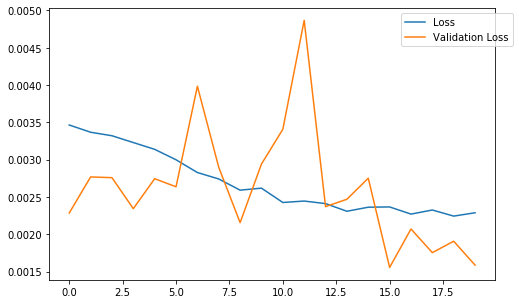

In [12]:
dict_ = model.history.history
plt.figure(figsize=(8,5))
plt.plot(dict_['loss'], label = 'Loss')
plt.plot(dict_['val_loss'], label= 'Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [13]:
predict_train = model.predict(feature_train)
predict_test = model.predict(feature_test)
r2_score(predict_test, label_test), r2_score(predict_train, label_train)

(-0.18987551099811828, -1.070850212661946)

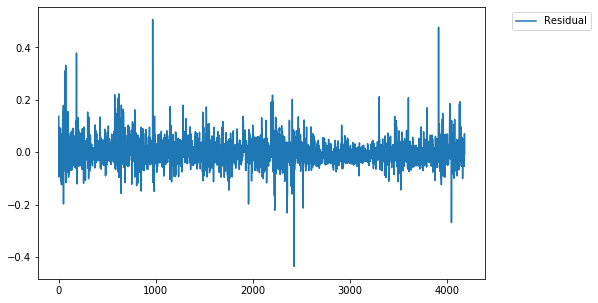

In [14]:
plt.figure(figsize=(8,5))
plt.plot(predict_train- label_train, label = 'Residual')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

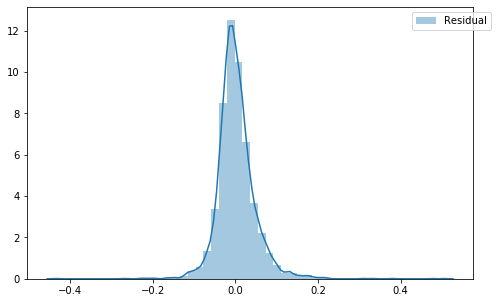

In [15]:
plt.figure(figsize=(8,5))
sns.distplot(predict_train- label_train, label = 'Residual')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [16]:
feature_train, label_train, feature_test, label_test = processed_data['SGMO']['data_1'],processed_data['SGMO']['target_1'], processed_data['SGMO']['data_test'], processed_data['SGMO']['target_test'] 
model.fit(feature_train, label_train, batch_size=100, epochs=20, validation_data = (feature_test, label_test),)

Train on 3805 samples, validate on 1169 samples
Epoch 1/20
3805/3805 [==============================] - 0s 96us/step - loss: 0.0024 - val_loss: 0.0018
Epoch 2/20
3805/3805 [==============================] - 0s 115us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 3/20
3805/3805 [==============================] - 0s 99us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 4/20
3805/3805 [==============================] - 0s 106us/step - loss: 0.0025 - val_loss: 0.0019
Epoch 5/20
3805/3805 [==============================] - 0s 98us/step - loss: 0.0023 - val_loss: 0.0027
Epoch 6/20
3805/3805 [==============================] - 0s 101us/step - loss: 0.0024 - val_loss: 0.0018
Epoch 7/20
3805/3805 [==============================] - 0s 112us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 8/20
3805/3805 [==============================] - 0s 98us/step - loss: 0.0023 - val_loss: 0.0017
Epoch 9/20
3805/3805 [==============================] - 0s 87us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 10/20
3805/3805

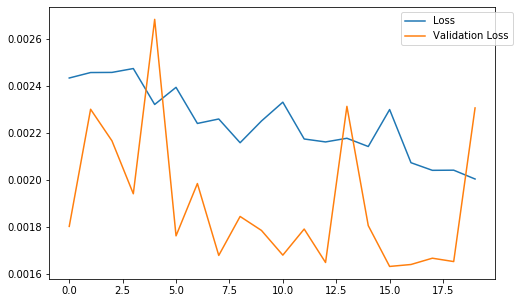

In [17]:
dict_ = model.history.history
plt.figure(figsize=(8,5))
plt.plot(dict_['loss'], label = 'Loss')
plt.plot(dict_['val_loss'], label= 'Validation Loss')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [18]:
predict_train = model.predict(feature_train)
predict_test = model.predict(feature_test)
r2_score(predict_test, label_test), r2_score(predict_train, label_train)


(-0.4449197890456531, -0.4759713601893738)

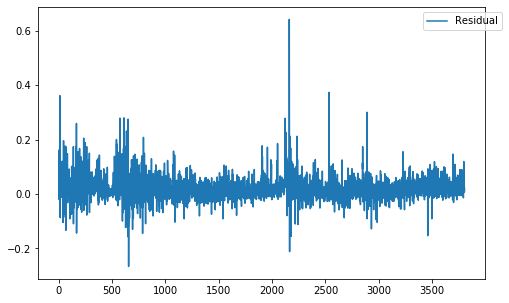

In [19]:
plt.figure(figsize=(8,5))
plt.plot(predict_train- label_train, label = 'Residual')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

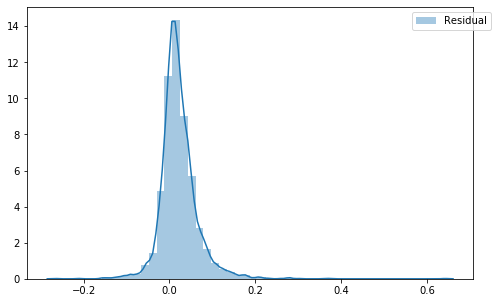

In [20]:
plt.figure(figsize=(8,5))
sns.distplot(predict_train- label_train, label = 'Residual')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()